In [1]:
import wandb
import os
import pickle
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd


def get_history(user="kealexanderwang", project="constrained-pnns", query={},
                **kwargs):
    api = wandb.Api()
    runs = api.runs(path=f"{user}/{project}", filters=query)
    dataframes = [run.history(**kwargs) for run in runs]
    if len(runs) == 0:
        return [[],[]]
    else:
        return list(zip(runs, dataframes))


def download_files(user="kealexanderwang", project="constrained-pnns",
                   query={}, save_dir=".", **kwargs):
    """
    Download the files of each run into a new directory for the run.
    Also saves the config dict of the run.
    """
    if not os.path.isdir(save_dir):
        os.mkdir(save_dir)

    api = wandb.Api()
    runs = api.runs(path=f"{user}/{project}", filters=query)
    for run in runs:
        name = run.name
        config = run.config

        run_dir = os.path.join(save_dir, name)
        if not os.path.isdir(run_dir):
            os.mkdir(run_dir)

        with open(os.path.join(run_dir, "config.pkl"), "wb") as h:
            pickle.dump(config, h)

        files = run.files()
        for file in files:
            file.download(root=run_dir)
    return

In [2]:
from pytorch_lightning import Trainer
from pl_trainer import DynamicsModel, SaveTestLogCallback
import os

def load_model_from_run(run, save_dir="/tmp"):
    name = run.display_name
    ckpt_save_path = os.path.join(save_dir, name)
    if not os.path.exists(ckpt_save_path):
        os.makedirs(ckpt_save_path)
     
    ckpts = sorted([f for f in run.files() if "checkpoints" in f.name])
    if len(ckpts) == 0:
        raise RuntimeError(f"Run {name} has no checkpoints!")
    # pick latest checkpoint if available
    last_ckpt = ckpts[-1]
    last_ckpt.download(replace=True, root=ckpt_save_path)
        
    ckpt_path = os.path.join(ckpt_save_path, last_ckpt.name)
    # Uncommet if you need the trainer
    pl_trainer = Trainer(resume_from_checkpoint=ckpt_path,logger=False)
    pl_model = DynamicsModel.load_from_checkpoint(ckpt_path)
    
    import pprint 
    pp = pprint.PrettyPrinter(indent=4)
    print("--------------------------------")
    print("Model Hyperparameters:")
    pp.pprint(vars(pl_model.hparams))
    print("--------------------------------")
    return pl_trainer, pl_model

def load_file_from_run(run, filename, save_dir="/tmp", replace=False):
    name = run.display_name
    save_path = os.path.join(save_dir, name)
    if not os.path.exists(save_path):
        os.makedirs(save_path)
    for f in run.files():
        if filename in f.name:
            file_path = os.path.join(save_path, f.name)
            if not os.path.exists(file_path):
                f.download(replace=replace, root=save_path)
            else:
                print("File already exists")
            return file_path
    raise ValueError("File not found in run!")

In [3]:
# See https://docs.wandb.com/library/reference/wandb_api for how to write queries

# Best trials
query = {"$and": 
             [{"$or": [
                 {"displayName": {"$in": ["brisk-flower-430", # NN on Rotor
                                 "quiet-night-429", #CLNN on Rotor
                                 "fragrant-pine-365", #CHNN on Rotor
                                 "sunny-feather-366", # HNN on Rotor died from NaNs
                                 "rosy-shadow-436", # LNN on Rotor stuck
                                 "magic-frost-437", # NN on Gyroscope   
                                 "gallant-durian-439", # CHNN on Gyroscope
                                 "super-vortex-440", # CLNN on Gyroscope
                                ]}},
                 {"$and": [{"tags": "data-efficiency"}, {"config.n_train": 800}]}]},
              {"state": "finished"},
              {"config.network_class": {"$ne": "LNN"}},
             ]
}


runs, histories = zip(*get_history(query=query))

In [5]:
import torch

labels = []
series = []

for run in runs:
    trainer, pl_model = load_model_from_run(run)
    pl_model.body.to(dtype=torch.float64)

    test_log_path = load_file_from_run(run, "test_log.pt")
    test_log = torch.load(test_log_path)

    pred_zts = test_log["pred_zts"]
    true_zts = test_log["true_zts"]
    pert_zts = test_log["pert_zts"]

    network_class = run.config["network_class"]
    body_args = tuple(run.config["body_args"])
    if len(body_args) == 0:
        body_args = ""
    elif len(body_args) == 1:
        body_args = f"({body_args[0]})"
    else:
        body_args = f"{body_args}"
    body = f"{run.config['body_class']}{body_args}"
    if body != "ChainPendulum(2)":
        continue
    
    true_energy_pred = pl_model.true_energy(pred_zts.to(torch.float64))
    true_energy_true = pl_model.true_energy(true_zts.to(torch.float64))
    true_energy_pert = pl_model.true_energy(pert_zts.to(torch.float64))
    
    true_energy_rel_diff_pred_true = (true_energy_pred - true_energy_true).div(true_energy_pred + true_energy_true).abs().cpu().numpy()

    series += true_energy_rel_diff_pred_true.tolist()
    labels += [(body, network_class, "true_energy_rel_diff_pred_true", batch) for batch in range(len(true_energy_rel_diff_pred_true))]

INFO:lightning:GPU available: True, used: False


CH ignores angular_dims
CH currently assumes potential energy depends only on q
CH currently assumes time independent Hamiltonian
CH assumes positions q are in Cartesian coordinates
--------------------------------
Model Hyperparameters:
{   'angular_dims': range(0, 5),
    'batch_size': 800,
    'body_args': [5],
    'body_class': 'ChainPendulum',
    'callbacks': [   <pytorch_lightning.callbacks.lr_logger.LearningRateLogger object at 0x7f49d23ac6d0>,
    'check_val_every_n_epoch': 100,
    'chunk_len': 5,
    'ckpt_dir': '/home/alex_w/repos/hamiltonian-biases/experiments/ChainPendulumn5m1l1/CHNN/wandb/run-20200506_222109-2d3zj9wh/constrained-pnns/version_2d3zj9wh/checkpoints',
    'dataset_class': 'RigidBodyDataset',
    'debug': False,
    'dof_ndim': 2,
    'dt': 0.1,
    'euclidean': True,
    'exp_dir': '/home/alex_w/repos/hamiltonian-biases/experiments/ChainPendulumn5m1l1/CHNN',
    'fast_dev_run': False,
    'gpus': 1,
    'hidden_size': 200,
    'integration_time': 10.0,
    '

INFO:lightning:GPU available: True, used: False


CH ignores angular_dims
CH currently assumes potential energy depends only on q
CH currently assumes time independent Hamiltonian
CH assumes positions q are in Cartesian coordinates
--------------------------------
Model Hyperparameters:
{   'angular_dims': range(0, 3),
    'batch_size': 800,
    'body_args': [3],
    'body_class': 'ChainPendulum',
    'callbacks': [   <pytorch_lightning.callbacks.lr_logger.LearningRateLogger object at 0x7f49d23ac590>,
    'check_val_every_n_epoch': 100,
    'chunk_len': 5,
    'ckpt_dir': '/home/alex_w/repos/hamiltonian-biases/experiments/ChainPendulumn3m1l1/CHNN/wandb/run-20200506_184402-3qfqmpge/constrained-pnns/version_3qfqmpge/checkpoints',
    'dataset_class': 'RigidBodyDataset',
    'debug': False,
    'dof_ndim': 2,
    'dt': 0.1,
    'euclidean': True,
    'exp_dir': '/home/alex_w/repos/hamiltonian-biases/experiments/ChainPendulumn3m1l1/CHNN',
    'fast_dev_run': False,
    'gpus': 1,
    'hidden_size': 200,
    'integration_time': 10.0,
    '

INFO:lightning:GPU available: True, used: False
/home/alex/miniconda3/envs/ham37v2/lib/python3.7/site-packages/torch/serialization.py:657: SourceChangeWarning: source code of class 'torch.nn.modules.container.ParameterDict' has changed. you can retrieve the original source code by accessing the object's source attribute or set `torch.nn.Module.dump_patches = True` and use the patch tool to revert the changes.
  warnings.warn(msg, SourceChangeWarning)


CH ignores angular_dims
CH currently assumes potential energy depends only on q
CH currently assumes time independent Hamiltonian
CH assumes positions q are in Cartesian coordinates
--------------------------------
Model Hyperparameters:
{   'angular_dims': range(0, 5),
    'batch_size': 800,
    'body_args': [5],
    'body_class': 'ChainPendulum',
    'callbacks': [   <pytorch_lightning.callbacks.lr_logger.LearningRateLogger object at 0x7f49d23a9750>,
    'check_val_every_n_epoch': 100,
    'chunk_len': 5,
    'ckpt_dir': '/home/alex_w/repos/hamiltonian-biases/experiments/ChainPendulumn5m1l1/CLNN/wandb/run-20200506_183748-17n0so64/constrained-pnns/version_17n0so64/checkpoints',
    'dataset_class': 'RigidBodyDataset',
    'debug': False,
    'dof_ndim': 2,
    'dt': 0.1,
    'euclidean': True,
    'exp_dir': '/home/alex_w/repos/hamiltonian-biases/experiments/ChainPendulumn5m1l1/CLNN',
    'fast_dev_run': False,
    'gpus': 1,
    'hidden_size': 200,
    'integration_time': 10.0,
    '

INFO:lightning:GPU available: True, used: False


CH ignores angular_dims
CH currently assumes potential energy depends only on q
CH currently assumes time independent Hamiltonian
CH assumes positions q are in Cartesian coordinates
--------------------------------
Model Hyperparameters:
{   'angular_dims': range(0, 3),
    'batch_size': 800,
    'body_args': [],
    'body_class': 'Gyroscope',
    'callbacks': [   <pytorch_lightning.callbacks.lr_logger.LearningRateLogger object at 0x7f49d235b790>,
    'check_val_every_n_epoch': 100,
    'chunk_len': 5,
    'ckpt_dir': '/home/alex_w/repos/hamiltonian-biases/experiments/Gyroscope/CLNN/wandb/run-20200506_164843-3524xjtc/constrained-pnns/version_3524xjtc/checkpoints',
    'dataset_class': 'RigidBodyDataset',
    'debug': False,
    'dof_ndim': 3,
    'dt': 0.1,
    'euclidean': True,
    'exp_dir': '/home/alex_w/repos/hamiltonian-biases/experiments/Gyroscope/CLNN',
    'fast_dev_run': False,
    'gpus': 1,
    'hidden_size': 200,
    'integration_time': 10.0,
    'logger': <pytorch_lightni

INFO:lightning:GPU available: True, used: False


CH ignores angular_dims
CH currently assumes potential energy depends only on q
CH currently assumes time independent Hamiltonian
CH assumes positions q are in Cartesian coordinates
--------------------------------
Model Hyperparameters:
{   'angular_dims': range(0, 3),
    'batch_size': 800,
    'body_args': [],
    'body_class': 'Gyroscope',
    'callbacks': [   <pytorch_lightning.callbacks.lr_logger.LearningRateLogger object at 0x7f49d2360550>,
    'check_val_every_n_epoch': 100,
    'chunk_len': 5,
    'ckpt_dir': '/home/alex_w/repos/hamiltonian-biases/experiments/Gyroscope/CHNN/wandb/run-20200506_164818-3h0xzg0w/constrained-pnns/version_3h0xzg0w/checkpoints',
    'dataset_class': 'RigidBodyDataset',
    'debug': False,
    'dof_ndim': 3,
    'dt': 0.1,
    'euclidean': True,
    'exp_dir': '/home/alex_w/repos/hamiltonian-biases/experiments/Gyroscope/CHNN',
    'fast_dev_run': False,
    'gpus': 1,
    'hidden_size': 200,
    'integration_time': 10.0,
    'logger': <pytorch_lightni

INFO:lightning:GPU available: True, used: False
/home/alex/miniconda3/envs/ham37v2/lib/python3.7/site-packages/torch/serialization.py:657: SourceChangeWarning: source code of class 'torch.nn.modules.activation.Softplus' has changed. you can retrieve the original source code by accessing the object's source attribute or set `torch.nn.Module.dump_patches = True` and use the patch tool to revert the changes.
  warnings.warn(msg, SourceChangeWarning)


tensor(3.6737e-07, dtype=torch.float64)
NN ignores wgrad
NN currently assumes time independent ODE
--------------------------------
Model Hyperparameters:
{   'angular_dims': range(0, 3),
    'batch_size': 800,
    'body_args': [],
    'body_class': 'Gyroscope',
    'callbacks': [   <pytorch_lightning.callbacks.lr_logger.LearningRateLogger object at 0x7f49d2339190>,
    'check_val_every_n_epoch': 100,
    'chunk_len': 5,
    'ckpt_dir': '/home/alex_w/repos/hamiltonian-biases/experiments/Gyroscope/NN/wandb/run-20200506_161029-24vu8dfq/constrained-pnns/version_24vu8dfq/checkpoints',
    'dataset_class': 'RigidBodyDataset',
    'debug': False,
    'dof_ndim': 3,
    'dt': 0.1,
    'euclidean': False,
    'exp_dir': '/home/alex_w/repos/hamiltonian-biases/experiments/Gyroscope/NN',
    'fast_dev_run': False,
    'gpus': 1,
    'hidden_size': 200,
    'integration_time': 10.0,
    'logger': <pytorch_lightning.loggers.wandb.WandbLogger object at 0x7f49d22e39d0>,
    'lr': 0.01,
    'max_epoch

INFO:lightning:GPU available: True, used: False


tensor(0.1559, dtype=torch.float64)
HNN currently assumes potential energy depends only on q
HNN currently assumes time independent Hamiltonian
--------------------------------
Model Hyperparameters:
{   'angular_dims': range(0, 5),
    'batch_size': 800,
    'body_args': [5],
    'body_class': 'ChainPendulum',
    'callbacks': [   <pytorch_lightning.callbacks.lr_logger.LearningRateLogger object at 0x7f49d23a1410>,
    'check_val_every_n_epoch': 100,
    'chunk_len': 5,
    'ckpt_dir': '/home/alex_w/repos/hamiltonian-biases/experiments/ChainPendulumn5m1l1/HNN/wandb/run-20200506_160135-7bze4jkz/constrained-pnns/version_7bze4jkz/checkpoints',
    'dataset_class': 'RigidBodyDataset',
    'debug': False,
    'dof_ndim': 5,
    'dt': 0.1,
    'euclidean': False,
    'exp_dir': '/home/alex_w/repos/hamiltonian-biases/experiments/ChainPendulumn5m1l1/HNN',
    'fast_dev_run': False,
    'gpus': 1,
    'hidden_size': 200,
    'integration_time': 10.0,
    'logger': <pytorch_lightning.loggers.wan

INFO:lightning:GPU available: True, used: False


tensor(0.1356, dtype=torch.float64)
NN ignores wgrad
NN currently assumes time independent ODE
--------------------------------
Model Hyperparameters:
{   'angular_dims': range(0, 5),
    'batch_size': 800,
    'body_args': [5],
    'body_class': 'ChainPendulum',
    'callbacks': [   <pytorch_lightning.callbacks.lr_logger.LearningRateLogger object at 0x7f49d229a4d0>,
    'check_val_every_n_epoch': 100,
    'chunk_len': 5,
    'ckpt_dir': '/home/alex_w/repos/hamiltonian-biases/experiments/ChainPendulumn5m1l1/NN/wandb/run-20200506_150913-19dopgw6/constrained-pnns/version_19dopgw6/checkpoints',
    'dataset_class': 'RigidBodyDataset',
    'debug': False,
    'dof_ndim': 5,
    'dt': 0.1,
    'euclidean': False,
    'exp_dir': '/home/alex_w/repos/hamiltonian-biases/experiments/ChainPendulumn5m1l1/NN',
    'fast_dev_run': False,
    'gpus': 1,
    'hidden_size': 200,
    'integration_time': 10.0,
    'logger': <pytorch_lightning.loggers.wandb.WandbLogger object at 0x7f49d22557d0>,
    'lr':

INFO:lightning:GPU available: True, used: False


tensor(4.7806e-08, dtype=torch.float64)
NN ignores wgrad
NN currently assumes time independent ODE
--------------------------------
Model Hyperparameters:
{   'angular_dims': range(3, 6),
    'batch_size': 800,
    'body_args': [],
    'body_class': 'Rotor',
    'callbacks': [   <pytorch_lightning.callbacks.lr_logger.LearningRateLogger object at 0x7f49d2238e50>,
    'check_val_every_n_epoch': 100,
    'chunk_len': 5,
    'ckpt_dir': '/home/alex_w/repos/hamiltonian-biases/experiments/Rotor/NN/wandb/run-20200506_140710-1omjaetp/constrained-pnns/version_1omjaetp/checkpoints',
    'dataset_class': 'RigidBodyDataset',
    'debug': False,
    'dof_ndim': 6,
    'dt': 0.1,
    'euclidean': False,
    'exp_dir': '/home/alex_w/repos/hamiltonian-biases/experiments/Rotor/NN',
    'fast_dev_run': False,
    'gpus': 1,
    'hidden_size': 200,
    'integration_time': 10.0,
    'logger': <pytorch_lightning.loggers.wandb.WandbLogger object at 0x7f49d21f7990>,
    'lr': 0.01,
    'max_epochs': 2000,
  

INFO:lightning:GPU available: True, used: False


CH ignores angular_dims
CH currently assumes potential energy depends only on q
CH currently assumes time independent Hamiltonian
CH assumes positions q are in Cartesian coordinates
--------------------------------
Model Hyperparameters:
{   'angular_dims': range(3, 6),
    'batch_size': 800,
    'body_args': [],
    'body_class': 'Rotor',
    'callbacks': [   <pytorch_lightning.callbacks.lr_logger.LearningRateLogger object at 0x7f49d223aad0>,
    'check_val_every_n_epoch': 100,
    'chunk_len': 5,
    'ckpt_dir': '/home/alex_w/repos/hamiltonian-biases/experiments/Rotor/CLNN/wandb/run-20200506_140706-3cm2uddt/constrained-pnns/version_3cm2uddt/checkpoints',
    'dataset_class': 'RigidBodyDataset',
    'debug': False,
    'dof_ndim': 3,
    'dt': 0.1,
    'euclidean': True,
    'exp_dir': '/home/alex_w/repos/hamiltonian-biases/experiments/Rotor/CLNN',
    'fast_dev_run': False,
    'gpus': 1,
    'hidden_size': 200,
    'integration_time': 10.0,
    'logger': <pytorch_lightning.loggers.w

INFO:lightning:GPU available: True, used: False


CH ignores angular_dims
CH currently assumes potential energy depends only on q
CH currently assumes time independent Hamiltonian
CH assumes positions q are in Cartesian coordinates
--------------------------------
Model Hyperparameters:
{   'angular_dims': range(0, 3),
    'batch_size': 800,
    'body_args': [3],
    'body_class': 'ChainPendulum',
    'callbacks': [   <pytorch_lightning.callbacks.lr_logger.LearningRateLogger object at 0x7f49d222bb90>,
    'check_val_every_n_epoch': 100,
    'chunk_len': 5,
    'ckpt_dir': '/home/alex_w/repos/hamiltonian-biases/experiments/ChainPendulumn3m1l1/CLNN/wandb/run-20200506_120540-3i4m6ljc/constrained-pnns/version_3i4m6ljc/checkpoints',
    'dataset_class': 'RigidBodyDataset',
    'debug': False,
    'dof_ndim': 2,
    'dt': 0.1,
    'euclidean': True,
    'exp_dir': '/home/alex_w/repos/hamiltonian-biases/experiments/ChainPendulumn3m1l1/CLNN',
    'fast_dev_run': False,
    'gpus': 1,
    'hidden_size': 200,
    'integration_time': 10.0,
    '

INFO:lightning:GPU available: True, used: False


tensor(0.1654, dtype=torch.float64)
HNN currently assumes potential energy depends only on q
HNN currently assumes time independent Hamiltonian
--------------------------------
Model Hyperparameters:
{   'angular_dims': range(0, 3),
    'batch_size': 800,
    'body_args': [3],
    'body_class': 'ChainPendulum',
    'callbacks': [   <pytorch_lightning.callbacks.lr_logger.LearningRateLogger object at 0x7f49d2200910>,
    'check_val_every_n_epoch': 100,
    'chunk_len': 5,
    'ckpt_dir': '/home/alex_w/repos/hamiltonian-biases/experiments/ChainPendulumn3m1l1/HNN/wandb/run-20200506_115408-2smgm5ci/constrained-pnns/version_2smgm5ci/checkpoints',
    'dataset_class': 'RigidBodyDataset',
    'debug': False,
    'dof_ndim': 3,
    'dt': 0.1,
    'euclidean': False,
    'exp_dir': '/home/alex_w/repos/hamiltonian-biases/experiments/ChainPendulumn3m1l1/HNN',
    'fast_dev_run': False,
    'gpus': 1,
    'hidden_size': 200,
    'integration_time': 10.0,
    'logger': <pytorch_lightning.loggers.wan

INFO:lightning:GPU available: True, used: False


CH ignores angular_dims
CH currently assumes potential energy depends only on q
CH currently assumes time independent Hamiltonian
CH assumes positions q are in Cartesian coordinates
--------------------------------
Model Hyperparameters:
{   'angular_dims': range(0, 2),
    'batch_size': 800,
    'body_args': [2],
    'body_class': 'ChainPendulum',
    'callbacks': [   <pytorch_lightning.callbacks.lr_logger.LearningRateLogger object at 0x7f49d222b150>,
    'check_val_every_n_epoch': 100,
    'chunk_len': 5,
    'ckpt_dir': '/home/alex_w/repos/hamiltonian-biases/experiments/ChainPendulumn2m1l1/CHNN/wandb/run-20200506_115243-1f5yliqc/constrained-pnns/version_1f5yliqc/checkpoints',
    'dataset_class': 'RigidBodyDataset',
    'debug': False,
    'dof_ndim': 2,
    'dt': 0.1,
    'euclidean': True,
    'exp_dir': '/home/alex_w/repos/hamiltonian-biases/experiments/ChainPendulumn2m1l1/CHNN',
    'fast_dev_run': False,
    'gpus': 1,
    'hidden_size': 200,
    'integration_time': 10.0,
    '

ipdb>  self.body.M.shape


torch.Size([2, 2])


ipdb>  qdot.shape


torch.Size([100, 100, 1, 2, 2])


ipdb>  zs.shape


torch.Size([100, 100, 2, 2, 2])


ipdb>  self


DynamicsModel(
  (model): CHNN(
    (dynamics): ConstrainedHamiltonianDynamics()
    (potential_net): Sequential(
      (0): Sequential(
        (0): Linear(in_features=4, out_features=200, bias=True)
        (1): Tanh()
      )
      (1): Sequential(
        (0): Linear(in_features=200, out_features=200, bias=True)
        (1): Tanh()
      )
      (2): Sequential(
        (0): Linear(in_features=200, out_features=200, bias=True)
        (1): Tanh()
      )
      (3): Linear(in_features=200, out_features=1, bias=True)
      (4): Reshape()
    )
  )
)


ipdb>  c


> /mnt/storage1/Documents/repos/hamiltonian-biases/pl_trainer.py(285)true_energy()
    283         q, qdot = zs.chunk(2, dim=2)
    284         breakpoint()
--> 285         p = self.body.M @ qdot
    286         zs = torch.cat([q, p], dim=2)
    287         energy = self.body.hamiltonian(None, zs.reshape(N * T, -1))



ipdb>  self


DynamicsModel(
  (model): CHNN(
    (dynamics): ConstrainedHamiltonianDynamics()
    (potential_net): Sequential(
      (0): Sequential(
        (0): Linear(in_features=4, out_features=200, bias=True)
        (1): Tanh()
      )
      (1): Sequential(
        (0): Linear(in_features=200, out_features=200, bias=True)
        (1): Tanh()
      )
      (2): Sequential(
        (0): Linear(in_features=200, out_features=200, bias=True)
        (1): Tanh()
      )
      (3): Linear(in_features=200, out_features=1, bias=True)
      (4): Reshape()
    )
  )
)


ipdb>  c


> /mnt/storage1/Documents/repos/hamiltonian-biases/pl_trainer.py(285)true_energy()
    283         q, qdot = zs.chunk(2, dim=2)
    284         breakpoint()
--> 285         p = self.body.M @ qdot
    286         zs = torch.cat([q, p], dim=2)
    287         energy = self.body.hamiltonian(None, zs.reshape(N * T, -1))



ipdb>  self


DynamicsModel(
  (model): CHNN(
    (dynamics): ConstrainedHamiltonianDynamics()
    (potential_net): Sequential(
      (0): Sequential(
        (0): Linear(in_features=4, out_features=200, bias=True)
        (1): Tanh()
      )
      (1): Sequential(
        (0): Linear(in_features=200, out_features=200, bias=True)
        (1): Tanh()
      )
      (2): Sequential(
        (0): Linear(in_features=200, out_features=200, bias=True)
        (1): Tanh()
      )
      (3): Linear(in_features=200, out_features=1, bias=True)
      (4): Reshape()
    )
  )
)


ipdb>  c


INFO:lightning:GPU available: True, used: False


tensor(0.2247, dtype=torch.float64)
NN ignores wgrad
NN currently assumes time independent ODE
--------------------------------
Model Hyperparameters:
{   'angular_dims': range(0, 3),
    'batch_size': 800,
    'body_args': [3],
    'body_class': 'ChainPendulum',
    'callbacks': [   <pytorch_lightning.callbacks.lr_logger.LearningRateLogger object at 0x7f49d2238950>,
    'check_val_every_n_epoch': 100,
    'chunk_len': 5,
    'ckpt_dir': '/home/alex_w/repos/hamiltonian-biases/experiments/ChainPendulumn3m1l1/NN/wandb/run-20200506_090832-20q60w3n/constrained-pnns/version_20q60w3n/checkpoints',
    'dataset_class': 'RigidBodyDataset',
    'debug': False,
    'dof_ndim': 3,
    'dt': 0.1,
    'euclidean': False,
    'exp_dir': '/home/alex_w/repos/hamiltonian-biases/experiments/ChainPendulumn3m1l1/NN',
    'fast_dev_run': False,
    'gpus': 1,
    'hidden_size': 200,
    'integration_time': 10.0,
    'logger': <pytorch_lightning.loggers.wandb.WandbLogger object at 0x7f49d2255210>,
    'lr':

INFO:lightning:GPU available: True, used: False


tensor(0.0933, dtype=torch.float64)
HNN currently assumes potential energy depends only on q
HNN currently assumes time independent Hamiltonian
--------------------------------
Model Hyperparameters:
{   'angular_dims': range(0, 2),
    'batch_size': 800,
    'body_args': [2],
    'body_class': 'ChainPendulum',
    'callbacks': [   <pytorch_lightning.callbacks.lr_logger.LearningRateLogger object at 0x7f49d2255f90>,
    'check_val_every_n_epoch': 100,
    'chunk_len': 5,
    'ckpt_dir': '/home/alex_w/repos/hamiltonian-biases/experiments/ChainPendulumn2m1l1/HNN/wandb/run-20200506_084526-3vlha2pp/constrained-pnns/version_3vlha2pp/checkpoints',
    'dataset_class': 'RigidBodyDataset',
    'debug': False,
    'dof_ndim': 2,
    'dt': 0.1,
    'euclidean': False,
    'exp_dir': '/home/alex_w/repos/hamiltonian-biases/experiments/ChainPendulumn2m1l1/HNN',
    'fast_dev_run': False,
    'gpus': 1,
    'hidden_size': 200,
    'integration_time': 10.0,
    'logger': <pytorch_lightning.loggers.wan

ipdb>  self


DynamicsModel(
  (model): HNN(
    (potential_net): Sequential(
      (0): CosSin()
      (1): Sequential(
        (0): Linear(in_features=4, out_features=200, bias=True)
        (1): Softplus(beta=1, threshold=20)
      )
      (2): Sequential(
        (0): Linear(in_features=200, out_features=200, bias=True)
        (1): Softplus(beta=1, threshold=20)
      )
      (3): Sequential(
        (0): Linear(in_features=200, out_features=200, bias=True)
        (1): Softplus(beta=1, threshold=20)
      )
      (4): Linear(in_features=200, out_features=1, bias=True)
      (5): Reshape()
    )
    (mass_net): Sequential(
      (0): CosSin()
      (1): Sequential(
        (0): Linear(in_features=4, out_features=200, bias=True)
        (1): Softplus(beta=1, threshold=20)
      )
      (2): Sequential(
        (0): Linear(in_features=200, out_features=200, bias=True)
        (1): Softplus(beta=1, threshold=20)
      )
      (3): Sequential(
        (0): Linear(in_features=200, out_features=200, 

ipdb>  self.body.M.shape


torch.Size([2, 2])


ipdb>  z.shape


*** NameError: name 'z' is not defined


ipdb>  zs.shape


torch.Size([100, 100, 2, 2, 2])


ipdb>  q


BdbQuit: 

In [13]:
levels = ['Body', 'Network', "Series", "Batch"]
index = pd.MultiIndex.from_tuples(labels, names=levels)
df = pd.DataFrame(series, index=index).reset_index()

In [14]:
df.head()

,Body,Network,Series,Batch,0,1,2,3,4,5,...,90,91,92,93,94,95,96,97,98,99
0,ChainPendulum(5),CHNN,true_energy_rel_diff_pred_true,0,0.000000e+00,0.000782,0.002512,0.004708,0.006219,0.006884,...,0.015250,0.016923,0.017402,0.016667,0.015589,0.013728,0.011797,0.010003,0.003894,0.000190
1,ChainPendulum(5),CHNN,true_energy_rel_diff_pred_true,1,0.000000e+00,0.000679,0.001313,0.001717,0.001754,0.001563,...,0.008827,0.010369,0.011746,0.013285,0.014656,0.014775,0.013472,0.011426,0.008452,0.004770
2,ChainPendulum(5),CHNN,true_energy_rel_diff_pred_true,2,2.046552e-16,0.003767,0.001478,0.001367,0.000383,0.007249,...,0.005116,0.012972,0.020012,0.021114,0.020812,0.023028,0.026563,0.028881,0.026799,0.020300
3,ChainPendulum(5),CHNN,true_energy_rel_diff_pred_true,3,0.000000e+00,0.000513,0.001644,0.002896,0.003467,0.004780,...,0.006417,0.006689,0.008697,0.013182,0.018327,0.019993,0.018618,0.016193,0.012762,0.009611
4,ChainPendulum(5),CHNN,true_energy_rel_diff_pred_true,4,0.000000e+00,0.000304,0.004485,0.009623,0.010069,0.013268,...,0.112145,0.068643,0.037658,0.020187,0.008057,0.006254,0.027025,0.062952,0.049891,0.017758


In [15]:
dt = run.config["dt"]
integration_time = run.config["integration_time"]
chunk_len = run.config["chunk_len"] * dt
n_timesteps = int(integration_time / dt)

In [16]:
df = df.rename(columns={i: dt * i for i in range(n_timesteps)})

In [17]:
df = pd.melt(df, id_vars=levels, var_name="time")

In [18]:
df = df.sort_values(by=levels)

In [139]:
sns.set(font_scale=1.25)
sns.set_style('whitegrid')
sns.set_palette(sns.color_palette("Set1", n_colors=6, desat=.67))
#import matplotlib as mpl
#mpl.rcParams['figure.dpi'] = 1000

In [140]:
df["Body"].unique()

array(['ChainPendulum(1)', 'ChainPendulum(2)', 'ChainPendulum(3)',
       'ChainPendulum(5)', 'Gyroscope', 'Rotor'], dtype=object)

In [141]:
data

,Body,Network,Series,Batch,time,value
2100,Rotor,CHNN,true_energy_rel_diff_pred_true,0,0,4.685350e-16
4300,Rotor,CHNN,true_energy_rel_diff_pred_true,0,0.1,1.086220e-05
6500,Rotor,CHNN,true_energy_rel_diff_pred_true,0,0.2,2.286573e-05
8700,Rotor,CHNN,true_energy_rel_diff_pred_true,0,0.3,3.586239e-05
10900,Rotor,CHNN,true_energy_rel_diff_pred_true,0,0.4,4.970448e-05
...,...,...,...,...,...,...
209899,Rotor,NN,true_energy_rel_diff_pred_true,99,9.5,8.269920e-01
212099,Rotor,NN,true_energy_rel_diff_pred_true,99,9.6,8.334493e-01
214299,Rotor,NN,true_energy_rel_diff_pred_true,99,9.7,8.393369e-01
216499,Rotor,NN,true_energy_rel_diff_pred_true,99,9.8,8.447063e-01


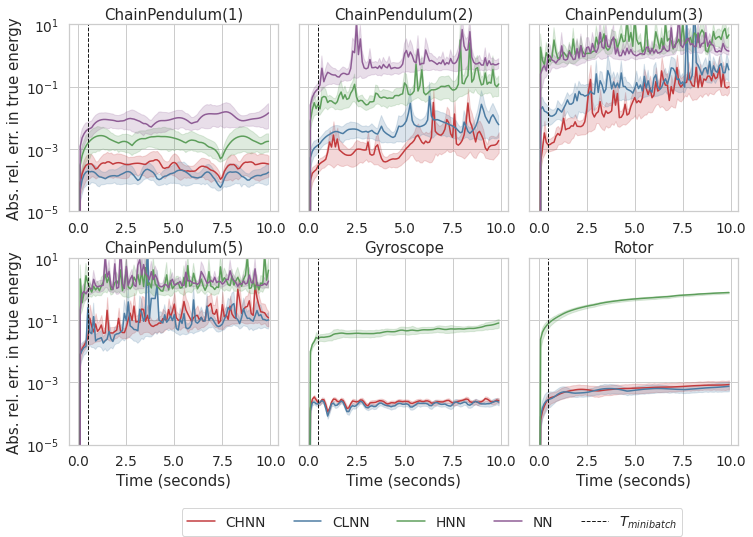

In [184]:
n_plots = len(df["Body"].unique())
ncols = n_plots //2
fig, axes = plt.subplots(nrows=2, ncols=ncols, figsize=(4 * n_plots // 2, 4 * 2))

i = 0
for value, ax in zip(df["Body"].unique(), axes.flatten()):
    data = df.loc[(df["Series"] == "true_energy_rel_diff_pred_true") & (df["Body"] == value)]
    
    sns.lineplot(data=data, x="time", y="value", hue="Network", ax=ax, ci=95)
    ax.axvline(chunk_len, label=r"$T_{minibatch}$", color="k", linestyle="--", linewidth=1.0)
    
    ax.set(yscale="log", xlabel="", title=f"{value}", ylim=(1e-5, 10), ylabel="")
    
    if i % ncols != 0: # hack
        ax.set(yticklabels=[])
    
    ax.legend().remove()
    i += 1

axes[0][0].set(ylabel="Abs. rel. err. in true energy")
axes[1][0].set(ylabel="Abs. rel. err. in true energy")
#axes[0][0].set(yticklabels=)

for i in range(n_plots // 2):
    axes[-1][i].set(xlabel="Time (seconds)")

handles, labels = axes[0][0].get_legend_handles_labels()
handles = handles[1:]
labels = labels[1:] # Get rid of legend title
fig.subplots_adjust(bottom=0.15, wspace=0.05, hspace=0.25)
fig.legend(handles=handles, labels=labels, bbox_to_anchor=(0., 0., 1.0, 0.1), loc="lower center", ncol=len(labels), borderaxespad=0.1)

In [185]:
fig.savefig("energy-conservation.pdf", bbox_inches="tight")